In [74]:
import json
import numpy as np
from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from hyperopt import hp, fmin, tpe, Trials
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.utils import to_categorical
import os
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# os.chdir(os.path.dirname(os.path.dirname(os.path.abspath('CNN-RNN-binary.ipynb'))))
os.chdir('/Users/ruotsing/PycharmProjects/DMS')


In [75]:

with open('preprocess_data/lateral_acceleration_data.json', 'r') as f:
    LA_data = json.load(f)
    
    
with open('preprocess_data/SWA_data.json', 'r') as f:
    SWA_data = json.load(f)

with open('preprocess_data/lateral_displacement_data.json', 'r') as f:
    LD_data = json.load(f)
    
with open('preprocess_data/YA_data.json', 'r') as f:
    YA_data = json.load(f)
    
with open('preprocess_data/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
    
def time_derivative(data, time_interval):
    data_dt = {}
    for name in data.keys():
        delta_displacement = np.diff(data[name])
        data_dt[name] = np.gradient(delta_displacement, time_interval)
    return data_dt

def simulate_decrease_sample_rate_regular(data,original_rate,target_rate):
    processed_data = {}
    for name in data.keys():
        processed_data[name] = []
        for i in range(0, len(data[name]), int(original_rate/target_rate)):
            processed_data[name].append(data[name][i])
    return processed_data

original_sample_rate = 100
target_sample_rate = 30

LA_data = simulate_decrease_sample_rate_regular(LA_data, original_sample_rate, target_sample_rate)
SWA_data = simulate_decrease_sample_rate_regular(SWA_data, original_sample_rate, target_sample_rate)
LD_data = simulate_decrease_sample_rate_regular(LD_data, original_sample_rate, target_sample_rate)
YA_data = simulate_decrease_sample_rate_regular(YA_data, original_sample_rate, target_sample_rate)


sample_rate = target_sample_rate
SWV_data= time_derivative(SWA_data, 1/sample_rate)
YR_data= time_derivative(YA_data, 1/sample_rate)

#standardize the data
def standardize(data):
    data_standard = {}
    for name in data.keys():
        data_standard[name] = (data[name] - np.mean(data[name]))/np.std(data[name])
    return data_standard

YR_standard = standardize(YR_data)
SWA_standard = standardize(SWA_data)
SWV_standard = standardize(SWV_data)
LD_standard = standardize(LD_data)
LA_standard = standardize(LA_data)

#apply the time window
size_= 10
step = 1
ground_truth=reform_ground_truth(ground_truth)
awake_window, _, drowsy_window=ground_truth_sep(ground_truth,size_,step) #ignoew the light drowsy state

def define_feature_matrix(window, data):
    feature_matrix = []
    for name in window.keys():
        for i in range(len(window[name])):
            begin = window[name][i][0]*sample_rate
            end = (window[name][i][-1]+1)*sample_rate
            feature_matrix.append(data[name][begin:end])
    return np.array(feature_matrix)
    

awake_YR_feature = define_feature_matrix(awake_window, YR_standard)
awake_SWA_feature = define_feature_matrix(awake_window, SWA_standard)
awake_SWV_feature = define_feature_matrix(awake_window, SWV_standard)
awake_LD_feature = define_feature_matrix(awake_window, LD_standard)
awake_LA_feature = define_feature_matrix(awake_window, LA_standard)
awake_feature_matrix=np.dstack((awake_YR_feature, awake_SWA_feature, awake_SWV_feature, awake_LD_feature, awake_LA_feature))
awake_label = np.ones(awake_feature_matrix.shape[0])*0

drowsy_YR_feature = define_feature_matrix(drowsy_window, YR_standard)
drowsy_SWA_feature = define_feature_matrix(drowsy_window, SWA_standard)
drowsy_SWV_feature = define_feature_matrix(drowsy_window, SWV_standard)
drowsy_LD_feature = define_feature_matrix(drowsy_window, LD_standard)
drowsy_LA_feature = define_feature_matrix(drowsy_window, LA_standard)
drowsy_feature_matrix=np.dstack((drowsy_YR_feature, drowsy_SWA_feature, drowsy_SWV_feature, drowsy_LD_feature, drowsy_LA_feature))
drowsy_label=np.ones(drowsy_feature_matrix.shape[0])


feature_matrix=np.concatenate((awake_feature_matrix, drowsy_feature_matrix), axis=0)
label=np.concatenate((awake_label, drowsy_label), axis=0)
label=label.astype(int)

In [76]:

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, label, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


In [77]:

def make_model(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.LSTM(space['neurons_lstm'][best_params['neurons_lstm']]),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=space['learning_rate'][best_params['learning_rate']]), loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=[Recall(),Precision(),AUC()]) #maybe change the loss function
    return model

In [78]:

def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    y_pred=[]
    for row in model.predict(X_test):
        y_pred.append(np.argmax(row))
    y_pred=np.array(y_pred) 
    cm = confusion_matrix(y_test, y_pred)
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('Precision:', cm[1,1]/(cm[1,1]+cm[0,1]))
    print('specificity:', cm[0,0]/(cm[0,0]+cm[0,1]))
    print('sensitivity:', cm[1,1]/(cm[1,1]+cm[1,0]))
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Awake', 'Drowsy'], yticklabels=['Awake', 'Drowsy'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()
    

In [79]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / len(awake_label)) * (len(label) / 2.0) #awake
weight_for_1 = (1 / len(drowsy_label)) * (len(label) / 2.0) #drowsy

class_weight = {0: weight_for_0, 1: weight_for_1}

In [80]:
space = {
    'conv_filters_1': hp.choice('conv_filters_1', [32, 64, 128]),
    'conv_filters_2': hp.choice('conv_filters_2', [32, 64, 128]),
    'conv_filters_3': hp.choice('conv_filters_3', [32, 64, 128]),
    'conv_filters_4': hp.choice('conv_filters_4', [32, 64, 128]),
    'mini_batch_size': hp.choice('mini_batch_size', [32, 64, 128]),
    'learning_rate': hp.choice('learning_rate', [0.001, 0.005, 0.01]),
    'pooling_size_hyperopt': hp.choice('pooling_size_hyperopt', [2,3]),
    'neurons_lstm': hp.choice('neurons_lstm', [32, 64, 128]),
    'neurons_gru': hp.choice('neurons_gru', [32, 64, 128])
}

space_params = {
    'conv_filters_1': [32, 64, 128],
    'conv_filters_2': [32, 64, 128],
    'conv_filters_3': [32, 64, 128],
    'conv_filters_4': [32, 64, 128],
    'learning_rate': [0.001, 0.005, 0.01],
    'mini_batch_size': [32, 64, 128],
    'pooling_size_hyperopt': [2,3],
    'neurons_lstm': [32, 64, 128],
    'neurons_gru': [32, 64, 128]
}

In [81]:
def objective_weighted(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.LSTM(params['neurons_lstm']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax')
        # tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    mode='max'
)
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=[Recall(),Precision(),AUC()])
    model.fit(X_train, y_train, epochs=10, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight, callbacks=[early_stopping])
    f1=f1_score(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1))
    return -f1  # Hyperopt minimizes the objective function

trials = Trials()
# manual add initial trials
# {'conv_filters_1': 0, 'conv_filters_2': 0, 'conv_filters_3': 2, 'conv_filters_4': 1, 'learning_rate': 0, 'mini_batch_size': 2, 'neurons_gru': 2, 'neurons_lstm': 0, 'pooling_size_hyperopt': 2}
# idxs means how many trails made eg.[0,1,2] means 3 trails made
# vals means the value of each trail
# trials.insert_trial_doc({
#     'state': 2,  # JOB_STATE_DONE
#     'tid': 0,  # trial ID
#     'spec': None,
#     'result': {'loss': 0.0, 'status': 'ok'},  # 自定义的试验结果
#     'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'idxs': {'conv_filters_1': [0], 'conv_filters_2': [0], 'conv_filters_3': [0], 'conv_filters_4': [0], 'learning_rate': [0], 'mini_batch_size': [0], 'neurons_gru': [0], 'neurons_lstm': [0], 'pooling_size_hyperopt': [0]}, 'vals': {'conv_filters_1': [0], 'conv_filters_2': [0], 'conv_filters_3': [2], 'conv_filters_4': [1], 'learning_rate': [0], 'mini_batch_size': [2], 'neurons_gru': [2], 'neurons_lstm': [0], 'pooling_size_hyperopt': [2]}},
#     'exp_key': None,
#     'owner': None,
#     'version': 0,
#     'book_time': None,
#     'refresh_time': None,
# })

best_params_weighted = fmin(objective_weighted, space, algo=tpe.suggest, max_evals=30, trials=trials)
best_weighted_model = make_model(space_params, best_params_weighted)
best_weighted_model.fit(X_train, y_train, epochs=10, batch_size=space_params['mini_batch_size'][best_params_weighted['mini_batch_size']], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)

print("Best hyperparameters:", best_params_weighted)


  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step
 20/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
 40/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 60/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 79/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

  3%|▎         | 1/30 [00:22<10:41, 22.12s/trial, best loss: -0.07785234899328859]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step              
 11/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   
 20/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 27/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 40/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 53/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 66/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 79/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 89/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
101/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

  7%|▋         | 2/30 [00:56<13:46, 29.53s/trial, best loss: -0.18725617685305593]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step              
  9/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step   
 19/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 30/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 40/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 50/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 61/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 72/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 83/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 94/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

 10%|█         | 3/30 [02:17<23:51, 53.03s/trial, best loss: -0.18725617685305593]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step              
  9/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step   
 17/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 25/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 34/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 43/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 52/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 61/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 70/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 79/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 88/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 97/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

 13%|█▎        | 4/30 [04:14<33:50, 78.09s/trial, best loss: -0.18725617685305593]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step              
 10/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   
 19/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 28/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 37/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 46/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 55/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 64/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 73/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 82/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 91/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
100/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

 17%|█▋        | 5/30 [04:46<25:40, 61.64s/trial, best loss: -0.18725617685305593]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step              
 22/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   
 45/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 69/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 94/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 20%|██        | 6/30 [05:07<19:08, 47.86s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step              
  9/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   
 17/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 26/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 36/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 47/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 58/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 69/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 80/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 91/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

 23%|██▎       | 7/30 [06:01<19:04, 49.75s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step              
 14/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   
 29/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 41/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 55/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 69/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 83/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 97/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 27%|██▋       | 8/30 [06:41<17:09, 46.78s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step              
 11/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   
 23/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 36/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 45/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 57/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 68/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 81/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 93/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 30%|███       | 9/30 [07:00<13:18, 38.04s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step              
 11/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   
 27/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 44/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 61/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 79/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 96/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 33%|███▎      | 10/30 [07:37<12:31, 37.56s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step               
 10/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   
 21/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 35/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 50/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 66/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 82/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 97/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 37%|███▋      | 11/30 [08:09<11:21, 35.87s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step               
 15/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   
 33/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 50/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 67/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 86/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 40%|████      | 12/30 [08:23<08:45, 29.19s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step               
 10/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   
 20/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 30/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 40/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 50/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 60/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 70/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 80/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 90/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
100/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

 43%|████▎     | 13/30 [09:02<09:09, 32.33s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step               
  9/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   
 22/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 35/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 48/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 59/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 73/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 87/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
101/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 47%|████▋     | 14/30 [09:30<08:16, 31.04s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step                
 23/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
 46/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 74/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 50%|█████     | 15/30 [10:04<07:58, 31.91s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step               
 17/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
 35/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 54/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 73/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 92/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

 53%|█████▎    | 16/30 [10:28<06:51, 29.40s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step               
 18/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
 40/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 63/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 87/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
101/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 57%|█████▋    | 17/30 [10:49<05:50, 27.00s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step               
 11/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   
 19/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 31/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 43/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 54/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 66/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 78/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 89/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 99/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

 60%|██████    | 18/30 [11:59<07:57, 39.83s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step               
 14/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   
 25/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 34/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 45/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 56/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 68/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 80/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 93/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

 63%|██████▎   | 19/30 [12:44<07:34, 41.34s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step               
  9/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step   
 16/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 24/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 33/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 42/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 51/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 59/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 68/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 77/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 86/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 94/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

 67%|██████▋   | 20/30 [13:57<08:30, 51.05s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step                
 24/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
 47/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 69/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 93/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 70%|███████   | 21/30 [14:12<05:59, 40.00s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step               
 14/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   
 35/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 60/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 88/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 73%|███████▎  | 22/30 [14:31<04:30, 33.83s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step               
 19/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
 41/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 64/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 87/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 77%|███████▋  | 23/30 [14:41<03:07, 26.77s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step               
 12/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   
 24/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 36/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 46/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 55/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 64/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 75/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 86/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 97/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

 80%|████████  | 24/30 [15:05<02:34, 25.75s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step               
 16/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   
 32/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 48/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 64/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 80/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 93/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 83%|████████▎ | 25/30 [15:29<02:05, 25.17s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step               
 14/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   
 30/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 54/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 80/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 87%|████████▋ | 26/30 [15:49<01:34, 23.75s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step               
 17/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
 35/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 53/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 72/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 91/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

 90%|█████████ | 27/30 [16:07<01:05, 21.96s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step               
 14/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   
 27/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 41/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 56/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 71/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 85/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
100/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

 93%|█████████▎| 28/30 [16:28<00:43, 21.70s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step                 
 24/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 46/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 70/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 95/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 97%|█████████▋| 29/30 [16:41<00:19, 19.03s/trial, best loss: -0.19812583668005354]

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  1/103 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step               
 16/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   
 31/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 46/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 62/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 77/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 92/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

100%|██████████| 30/30 [17:12<00:00, 34.40s/trial, best loss: -0.19812583668005354]


/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best hyperparameters: {'conv_filters_1': 0, 'conv_filters_2': 1, 'conv_filters_3': 2, 'conv_filters_4': 0, 'learning_rate': 0, 'mini_batch_size': 1, 'neurons_gru': 0, 'neurons_lstm': 0, 'pooling_size_hyperopt': 1}


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Recall: 0.8311688311688312
F1: 0.2490272373540856
Precision: 0.14645308924485126
specificity: 0.8678242381289866
sensitivity: 0.8311688311688312


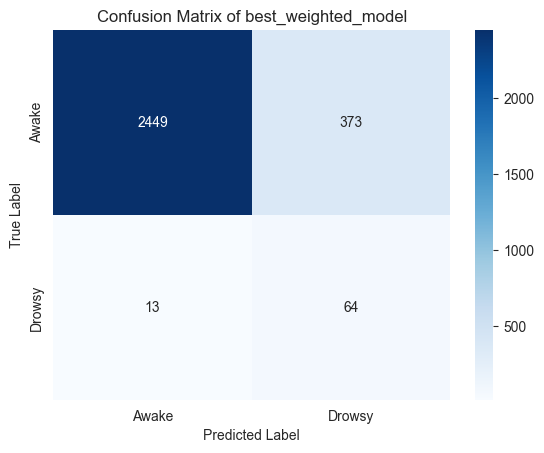

In [82]:

confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_test, y_test)

In [66]:
best_weighted_model.save('best_weighted_model.h5')

/Users/ruotsing/PycharmProjects/DMS/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Recall: 0.6883116883116883
F1: 0.7794117647058824
Precision: 0.8983050847457628
specificity: 0.9978738483345145
sensitivity: 0.6883116883116883


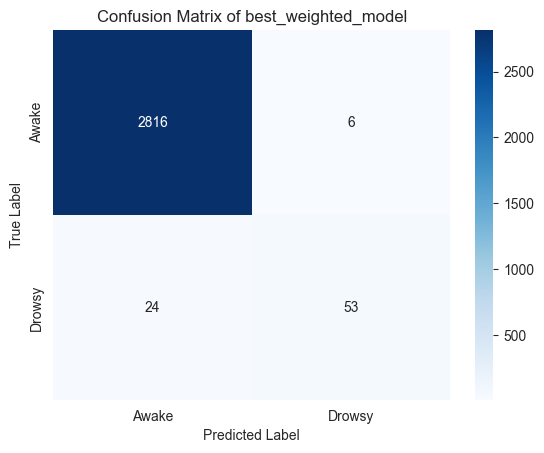

In [86]:
best_params_weighted={'conv_filters_1': 0, 'conv_filters_2': 0, 'conv_filters_3': 2, 'conv_filters_4': 1, 'learning_rate': 0, 'mini_batch_size': 2, 'neurons_gru': 0, 'neurons_lstm': 0, 'pooling_size_hyperopt': 1}


best_weighted_model = make_model(space_params, best_params_weighted)
best_weighted_model.fit(X_train, y_train, epochs=50, batch_size=space_params['mini_batch_size'][best_params_weighted['mini_batch_size']], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_test, y_test)